# This notebook finds the final MAPEs for all soybean test set combinations

### CONTENTS

### 1 Imports
### 2 Define error functions
### 3 Load and evaluate individual daily forecasts
### 4 Evaluate daily combinations
### 5 Load and evaluate individual weekly forecasts
### 6 Evaluate weekly combinations
### 7 Evaluate combination with weather

# 1 Imports

In [28]:
import numpy as np
import pandas as pd

from scipy import stats

import random

import matplotlib.pyplot as plt
import matplotlib.dates

from google.colab import drive
import json

# 2 Define error functions

In [29]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns mean absolute percentage error
def mape(forecast, actual):
  return np.mean(np.abs(forecast - actual)/np.abs(actual))

In [30]:
# Takes a forecast and its ground truth as 1-d arrays
# Returns root mean squared error
def rmse(forecast, valid):
    return (np.mean((forecast - valid)**2))**.5  # RMSE

# 3 Load and evaluate individual daily forecasts

In [31]:
# Get untampered validation set for error evaluation

# Import daily data
data_url = 'https://raw.githubusercontent.com/ptraver/data/main/bean_daily_V2.csv'
soybean_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
soybean_df.columns = ['value']

# take only 1974 - 2017
soybean_df = soybean_df['1974-01-01':'2017-12-31']

# soybean_df needs to lose last value becuase during process of VMD, the last value is lost
soybean_df = soybean_df[:-1]

# get test set
from sklearn.model_selection import train_test_split
true_train, out_of_sample = train_test_split(soybean_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)

In [32]:
# flatten the valid set for comparing with forecasts
true_test = true_test.values.flatten()

In [33]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
# Load emd_arima
with open('/content/gdrive/MyDrive/outputs/test/emd_ARIMA_daily_test.json') as fp:
  emd_arima = np.array(json.load(fp))

# Load vmd arima
with open('/content/gdrive/MyDrive/outputs/test/vmd_ARIMA_daily_test.json') as fp:
  vmd_arima = np.array(json.load(fp))

# Load emd_RNN
emd_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/emd_RNN_daily_test.npy')

# Load vmd_RNN
vmd_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/vmd_RNN_daily_test.npy')

# Load true_RNN
true_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/true_RNN_daily_test.npy')

In [35]:
# Check shapes
print(true_test.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)
print(true_RNN.shape)

(1109,)
(1109,)
(1109,)
(1109,)
(1109,)
(1109,)


In [36]:
# Check individual mape scores
print(mape(emd_arima, true_test))
print(mape(vmd_arima, true_test))
print(mape(emd_RNN, true_test))
print(mape(vmd_RNN, true_test))
print(mape(true_RNN, true_test))

0.006078513822887154
0.005026336427165053
0.009289699761276516
0.0056110940946201
0.01619166446516072


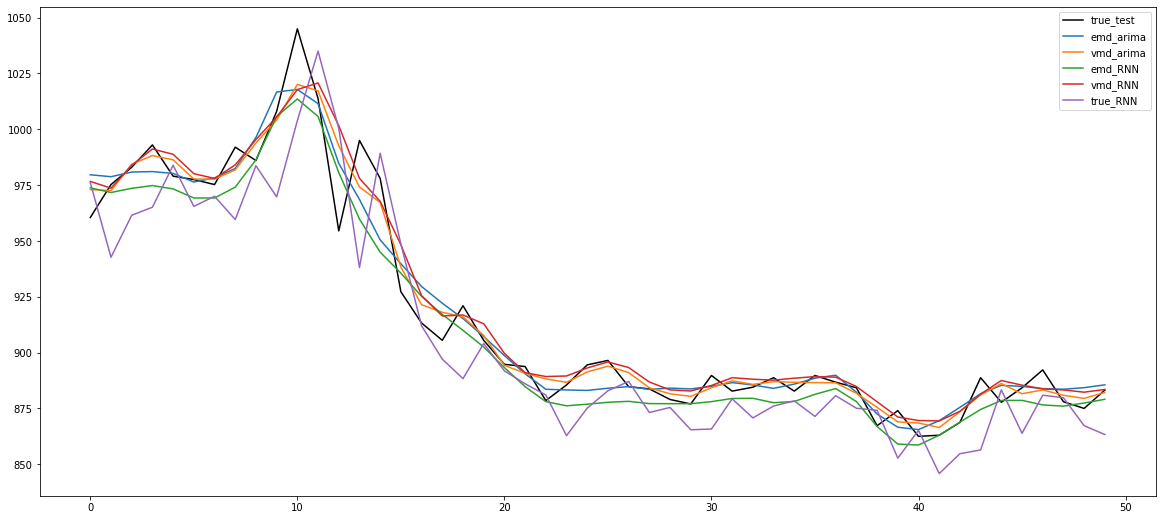

In [37]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_test[500:550], label='true_test', color='k')
plt.plot(emd_arima[500:550], label='emd_arima')
plt.plot(vmd_arima[500:550], label='vmd_arima')
plt.plot(emd_RNN[500:550], label='emd_RNN')
plt.plot(vmd_RNN[500:550], label='vmd_RNN')
plt.plot(true_RNN[500:550], label='true_RNN')
plt.legend()
plt.show()

In [38]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN, true_RNN]))
model_matrix

array([[1355.6420876 , 1352.75248341, 1344.71313477, 1353.27294922,
        1314.13562012],
       [1349.55525823, 1360.77962113, 1338.9107666 , 1359.69384766,
        1317.6348877 ],
       [1360.20765082, 1365.19548713, 1348.4395752 , 1367.44604492,
        1334.05529785],
       ...,
       [ 956.80461655,  957.2802316 ,  949.93023682,  960.39910889,
         946.96594238],
       [ 951.61726829,  953.55765133,  945.62670898,  956.01391602,
         942.95916748],
       [ 948.69466343,  950.86585462,  941.97528076,  953.10266113,
         938.80041504]])

# 4 Evaluate daily combinations

In [39]:
# 2-model

ABC_weights = [0.14707446, 0.85306499, 0, 0, 0]
EIDS_weights = [0.035992689177374686, 0.9640073108226255, 0, 0, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.005049766478266271
EIDS MAPE:  0.005024352873252969


In [40]:
# 4-model  - daily wang

ABC_weights = [ 0.44330457,  0.549319,   -0.0810808,   0.0967379, 0]
EIDS_weights = [0.3909324340461282, 0.6079703373110716, 0.005548026674517778, -0.0044507980317174435, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.009770065131803313
EIDS MAPE:  0.005212741912273084


In [41]:
# 5-model  -- DUD

ABC_weights = [ 0.19555525,  0.6095425,   0.1522833,   0.14449545, -0.10184843] 

EIDS_weights = [-0.1522742695386335, 0.9778204556762019, 0.2594210402976141, 0.1750839621857191, -0.26005118862090115] 


print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.005007389605711597
EIDS MAPE:  0.004951100358831556


# 5 Load and evaluate individual weekly forecasts

In [42]:
# Get untampered validation set for error evaluation

# Import daily data
data_url = 'https://raw.githubusercontent.com/kumars8/Deloitte_login_prjct/master/soybean_weekly.csv'
soybean_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
soybean_df.columns = ['value']

# take only 1974 - 2017
soybean_df = soybean_df['1974-01-01':'2017-12-31']

# soybean_df needs to lose last value becuase during process of VMD, the last value is lost
soybean_df = soybean_df[:-1]

# get validation set
from sklearn.model_selection import train_test_split
true_train, out_of_sample = train_test_split(soybean_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)

In [43]:
# flatten the valid set for comparing with forecasts
true_test = true_test.values.flatten()

In [44]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [45]:
# Load emd_arima
with open('/content/gdrive/MyDrive/outputs/test/emd_ARIMA_weekly_test.json') as fp:
  emd_arima = np.array(json.load(fp))

# Load vmd arima
with open('/content/gdrive/MyDrive/outputs/test/vmd_ARIMA_weekly_test.json') as fp:
  vmd_arima = np.array(json.load(fp))

# Load emd_RNN
emd_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/emd_RNN_weekly_test.npy')

# Load vmd_RNN
vmd_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/vmd_RNN_weekly_test.npy')

# Load true_RNN
true_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/true_RNN_weekly_test.npy')

In [46]:
# Check shapes
print(true_test.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)
print(true_RNN.shape)

(230,)
(230,)
(230,)
(230,)
(230,)
(230,)


In [47]:
# Check individual mape scores
print(mape(emd_arima, true_test))
print(mape(vmd_arima, true_test))
print(mape(emd_RNN, true_test))
print(mape(vmd_RNN, true_test))
print(mape(true_RNN, true_test))

0.010857412761397804
0.011192859305760593
0.015024402642054149
0.010816215901899748
0.020261146340025973


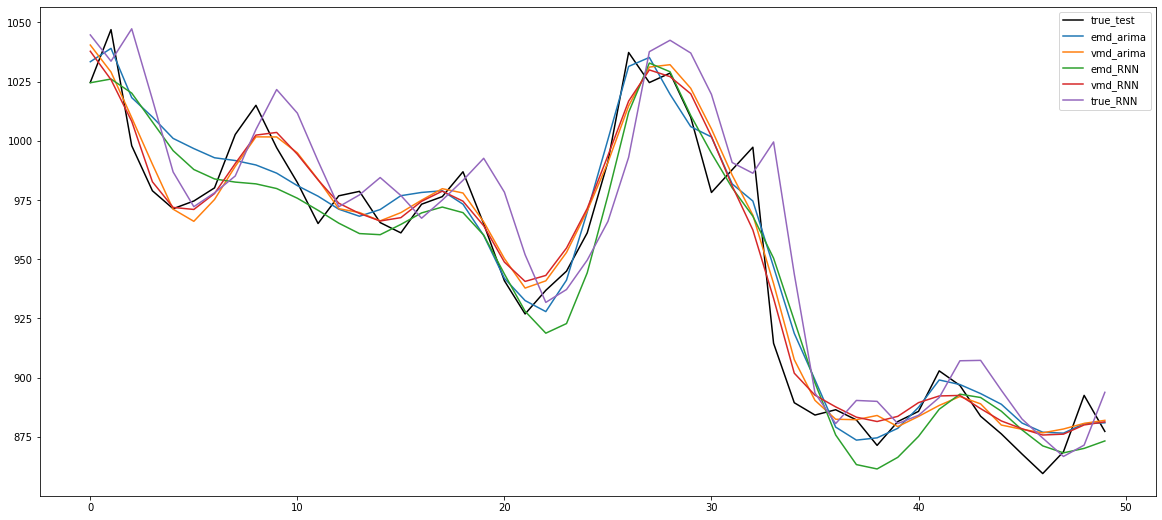

In [48]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_test[75:125], label='true_test', color='k')
plt.plot(emd_arima[75:125], label='emd_arima')
plt.plot(vmd_arima[75:125], label='vmd_arima')
plt.plot(emd_RNN[75:125], label='emd_RNN')
plt.plot(vmd_RNN[75:125], label='vmd_RNN')
plt.plot(true_RNN[75:125], label='true_RNN')
plt.legend()
plt.show()

In [49]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN, true_RNN]))
model_matrix

array([[1455.16805291, 1426.64056545, 1478.56604004, 1417.28173828,
        1515.10253906],
       [1398.92909875, 1374.05755178, 1410.69189453, 1379.79248047,
        1421.34924316],
       [1339.75025881, 1346.44182015, 1345.11437988, 1355.26318359,
        1355.07434082],
       ...,
       [ 976.63241352,  990.67989952,  970.31085205,  990.54296875,
         992.67852783],
       [ 978.73006868,  986.84366971,  970.28405762,  986.40496826,
         999.6036377 ],
       [ 977.69208825,  982.72005292,  970.23510742,  982.65338135,
        1005.04162598]])

# 6 Evaluate weekly combinations

In [50]:
# 2-model

ABC_weights = [0, 0.513688927525063, 0.51869816, 0, 0]
EIDS_weights = [0, 3.920261449448671, -2.920261449448693, 0, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.03001017770236195
EIDS MAPE:  0.038432605414626904


In [51]:
# 4-model

ABC_weights = [ 0.45806836,  0.15886572, -0.15844888,  0.54153477, 0]
EIDS_weights = [0.4479097235284617, -0.454300609087545, -0.08166069705266683, 1.0880515826117503, 0]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.010252101147395049
EIDS MAPE:  0.010300609258885103


In [52]:
# 5-model  -- DUD

ABC_weights = [ 0.26430236,  0.27570089,  0.23365987,  0.33248783, -0.1020451 ]

EIDS_weights = [0.40387205135974535, -0.2293663237088383, 0.01216344544365896, 0.9513556857473304, -0.13802485884189603]


print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.01022870939591757
EIDS MAPE:  0.00964553131973031


# 7 Evaluate combination with weather

In [53]:
# Load weather_RNN
true_RNN = np.load('/content/gdrive/MyDrive/outputs/test/daily/true_RNN_weather_test.npy')

In [54]:
# Reshape sets because the first few prediction values are not in weather prediction
true_test = true_test[4:]
emd_arima = emd_arima[4:]
vmd_arima = vmd_arima[4:]
emd_RNN = emd_RNN[4:]
vmd_RNN = vmd_RNN[4:]

In [55]:
# Check shapes
print(true_test.shape)
print(emd_arima.shape)
print(vmd_arima.shape)
print(emd_RNN.shape)
print(vmd_RNN.shape)
print(true_RNN.shape)

(226,)
(226,)
(226,)
(226,)
(226,)
(226,)


In [56]:
# Check individual mape scores
print(mape(emd_arima, true_test))
print(mape(vmd_arima, true_test))
print(mape(emd_RNN, true_test))
print(mape(vmd_RNN, true_test))
print(mape(true_RNN, true_test))

0.01065365997810083
0.01124708465720565
0.01472165421780625
0.01082665037843069
0.05321940361403002


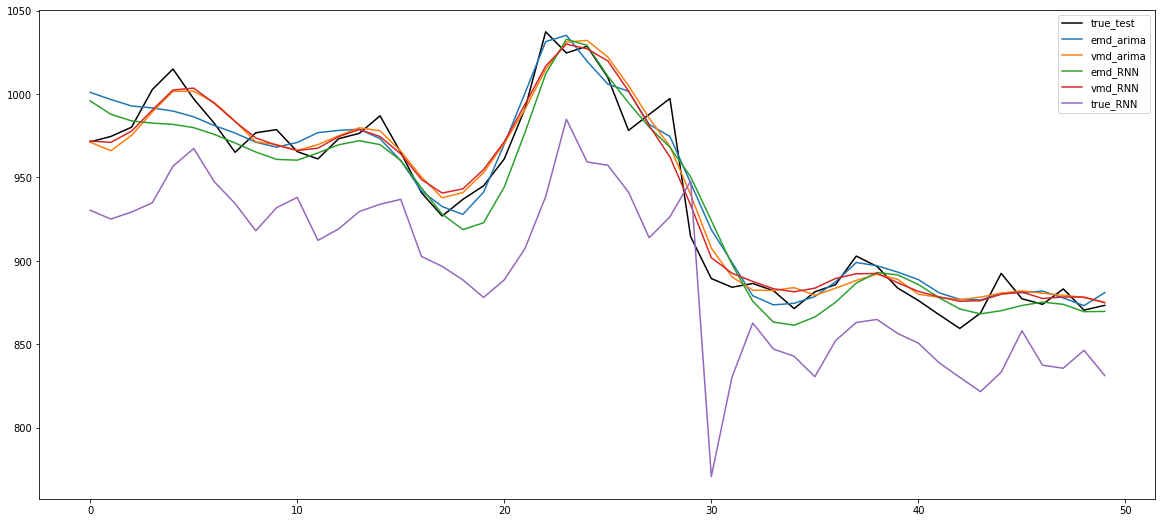

In [57]:
# Visualise subsection of results
plt.figure(figsize=(20,9))
plt.plot(true_test[75:125], label='true_test', color='k')
plt.plot(emd_arima[75:125], label='emd_arima')
plt.plot(vmd_arima[75:125], label='vmd_arima')
plt.plot(emd_RNN[75:125], label='emd_RNN')
plt.plot(vmd_RNN[75:125], label='vmd_RNN')
plt.plot(true_RNN[75:125], label='true_RNN')
plt.legend()
plt.show()

In [58]:
# Make model_matrix, taking all forecasts into single data structure
model_matrix = np.transpose(np.array([emd_arima, vmd_arima, emd_RNN, vmd_RNN, true_RNN]))
model_matrix

array([[1335.09084601, 1360.80678218, 1294.20300293, 1363.63134766,
        1261.58337402],
       [1418.13266561, 1377.34585665, 1348.1015625 , 1383.70019531,
        1271.08178711],
       [1457.11022913, 1396.58333966, 1419.77258301, 1407.13000488,
        1260.68310547],
       ...,
       [ 976.63241352,  990.67989952,  970.31085205,  990.54296875,
         946.24645996],
       [ 978.73006868,  986.84366971,  970.28405762,  986.40496826,
         945.2769165 ],
       [ 977.69208825,  982.72005292,  970.23510742,  982.65338135,
         950.76794434]])

In [59]:
# 5-model weather combination

ABC_weights = [ 0.28012628, 0.2921947, 0.21306359, 0.3121216, -0.10167462]
EIDS_weights = [0.49299862549589835, -0.20960551017720058, -0.1296738391434475, 0.8518308414908913, -0.005550117666140917]

print('ABC MAPE: ', mape(model_matrix.dot(ABC_weights), true_test))
print('EIDS MAPE: ', mape(model_matrix.dot(EIDS_weights), true_test))

ABC MAPE:  0.010254127637511571
EIDS MAPE:  0.010270754375230293
